In [64]:

from dotenv import load_dotenv
load_dotenv()
import os
import sys
sys.path.append(
    os.environ.get('WORK_DIR')) #type: ignore
sys.path.append(
    os.environ.get('DBASE_DIR')) #type: ignore
from dbase.DataAPI.ThetaData import * #type: ignore
from dbase.database.SQLHelpers import * #type: ignore
import pandas as pd
from EventDriven.data import HistoricTradeDataHandler
from EventDriven.event import *
from queue import Queue
from trade.backtester_.backtester_ import PTDataset, PTBacktester
import pandas_ta as ta
from trade.assets.Stock import Stock
from trade.backtester_.utils.WalkForwardUtils import prev_monday 
from trade.backtester_.strats import BBandsTrend2
from trade.backtester_.strats import MAStrat
import yfinance as yf
from datetime import datetime
from EventDriven.backtest import OptionSignalBacktest
from copy import deepcopy
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
thetadata_start = '2021-01-01'

In [66]:
import json
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
key = 9
with open(f'../input/profitable_weights_{key}.json', 'r') as f:
    weights = json.load(f)
ttrades__ = pd.read_csv(f'../input/profitable_trades_{key}.csv').iloc[:, 1:]
ttrades__['Duration'] = ttrades__.Duration.apply(lambda x: int(x.split(' ')[0]))
# ttrades__ = ttrades__[ttrades__.Duration>0]
ttrades__#.Ticker.unique()

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration,Ticker
0,13.0,506.0,509.0,602.009658,549.460022,-683.145269,-0.087290,2022-01-04,2022-01-07,3,NFLX
1,53.0,506.0,510.0,151.538529,129.080002,-1190.301966,-0.148203,2022-01-04,2022-01-10,6,AMD
2,15.0,506.0,510.0,566.204785,529.289978,-553.722111,-0.065197,2022-01-04,2022-01-10,6,COST
3,36.0,506.0,510.0,397.904471,333.333344,-2324.560587,-0.162278,2022-01-04,2022-01-10,6,TSLA
4,71.0,506.0,516.0,183.269210,170.000000,-942.113903,-0.072403,2022-01-04,2022-01-19,15,AAPL
5,16.0,511.0,518.0,520.615788,481.920013,-619.132389,-0.074327,2022-01-11,2022-01-21,10,COST
6,72.0,517.0,553.0,167.564426,151.449997,-1160.238871,-0.096169,2022-01-20,2022-03-14,53,AAPL
7,1193.0,519.0,521.0,22.408155,23.240000,992.390903,0.037122,2022-01-24,2022-01-26,2,NVDA
8,16.0,519.0,592.0,477.214413,496.100006,302.169494,0.039575,2022-01-24,2022-05-09,105,COST
9,60.0,520.0,523.0,114.499348,101.550003,-776.960725,-0.113095,2022-01-25,2022-01-28,3,AMD


In [67]:
trades_ = ttrades__.copy()
trades_

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration,Ticker
0,13.0,506.0,509.0,602.009658,549.460022,-683.145269,-0.087290,2022-01-04,2022-01-07,3,NFLX
1,53.0,506.0,510.0,151.538529,129.080002,-1190.301966,-0.148203,2022-01-04,2022-01-10,6,AMD
2,15.0,506.0,510.0,566.204785,529.289978,-553.722111,-0.065197,2022-01-04,2022-01-10,6,COST
3,36.0,506.0,510.0,397.904471,333.333344,-2324.560587,-0.162278,2022-01-04,2022-01-10,6,TSLA
4,71.0,506.0,516.0,183.269210,170.000000,-942.113903,-0.072403,2022-01-04,2022-01-19,15,AAPL
5,16.0,511.0,518.0,520.615788,481.920013,-619.132389,-0.074327,2022-01-11,2022-01-21,10,COST
6,72.0,517.0,553.0,167.564426,151.449997,-1160.238871,-0.096169,2022-01-20,2022-03-14,53,AAPL
7,1193.0,519.0,521.0,22.408155,23.240000,992.390903,0.037122,2022-01-24,2022-01-26,2,NVDA
8,16.0,519.0,592.0,477.214413,496.100006,302.169494,0.039575,2022-01-24,2022-05-09,105,COST
9,60.0,520.0,523.0,114.499348,101.550003,-776.960725,-0.113095,2022-01-25,2022-01-28,3,AMD


In [68]:
symbol_list = trades_.Ticker.unique()
untraded_symbols = [s for s in weights.keys() if s not in trades_.Ticker.unique()]
for s in untraded_symbols:
    weights.pop(s)
pd.Series(weights).sort_values(ascending=False)

NVDA    0.258200
TSLA    0.141689
AAPL    0.126342
COST    0.086172
NFLX    0.079848
AMD     0.078142
BA      0.063678
SBUX    0.062422
AMZN    0.057160
dtype: float64

In [69]:

from EventDriven.riskmanager import RiskManager, close_cache, spot_cache, chain_cache, oi_cache, LOOKBACKS, order_cache
from pandas.tseries.offsets import BDay

rm = RiskManager(None, None, 1000000)
rm.OrderPicker.liquidity_threshold = 2
rm.OrderPicker.lookback = 10
rm.OrderPicker.data_availability_threshold = 0.15
date, tick = '2023-07-05', 'AVGO'
date, tick = '2024-08-13', 'TSM'
start = (pd.to_datetime(date) - BDay(30)).strftime('%Y-%m-%d')
right = 'C'
order_settings = {'type': 'spread',
 'specifics': [{'direction': 'long',
   'rel_strike': .50,
   'dte': 210,
   'moneyness_width': 0.5},
  #  {'direction': 'short',
  # 'rel_strike': .60,
  # 'dte': 270,
  # 'moneyness_width': 0.35}
],
 'name': 'vertical_spread'}



order =  rm.OrderPicker.get_order(tick, date, right, 2, order_settings)
order

{'result': 'SUCCESSFUL',
 'data': {'long': ['TSM20250321C280'],
  'trade_id': '&L:TSM20250321C280',
  'close': 1.515}}

In [70]:
max_cash = {}
cash = 20_000
for s, w in weights.items():
    if w * cash > 200:
        max_cash[s] = 2
    elif w * cash > 100:
        max_cash[s] = 1
    else:
        max_cash[s] = 0.5
max_cash

{'NVDA': 2,
 'TSLA': 2,
 'AMD': 2,
 'AAPL': 2,
 'NFLX': 2,
 'COST': 2,
 'AMZN': 2,
 'BA': 2,
 'SBUX': 2}

In [71]:
#Backtest class 
## Find a way to not always reinitialize the backtest class, when want to redo

evb_backtest = OptionSignalBacktest(trades_, initial_capital=cash)

In [72]:
evb_backtest.portfolio.initial_capital

20000.0

In [73]:
w_map = {x: w  * 0.85 for x, w in weights.items()} ## 75% of the weights for each stock
evb_backtest.portfolio.weight_map = w_map
evb_backtest.portfolio.weight_map
evb_backtest.portfolio.risk_manager.OrderPicker.liquidity_threshold = 50
evb_backtest.portfolio.risk_manager.OrderPicker.lookback = 10
evb_backtest.portfolio.risk_manager.OrderPicker.data_availability_threshold = 0.5
evb_backtest.portfolio.order_settings = {'type': 'naked',
 'specifics': [{'direction': 'long',
   'rel_strike': .850,
   'dte': 300,
   'moneyness_width': 0.35},
   {'direction': 'short',
  'rel_strike': .60,
  'dte': 300,
  'moneyness_width': 0.35}
],
 'name': 'vertical_spread'}


evb_backtest.portfolio.max_contract_price = max_cash
evb_backtest.executor.commission_rate = 0.65/100
evb_backtest.executor.commission_rate
evb_backtest.executor.max_slippage_pct = 0.075
evb_backtest.portfolio.roll_map = 3
evb_backtest.portfolio.allocated_cash_map
evb_backtest.portfolio.max_contract_price
evb_backtest.portfolio.roll_map
evb_backtest.portfolio.allocated_cash_map
evb_backtest.portfolio.max_contract_price


{'NVDA': 2,
 'TSLA': 2,
 'AMD': 2,
 'AAPL': 2,
 'NFLX': 2,
 'COST': 2,
 'AMZN': 2,
 'BA': 2,
 'SBUX': 2}

In [74]:
for key  in max_cash:
    if max_cash[key]*100 > evb_backtest.portfolio.allocated_cash_map[key]:
        print(key, max_cash[key]*100, evb_backtest.portfolio.allocated_cash_map[key])

In [75]:
pd.options.display.max_rows = 15
pd.options.display.max_columns = 15
signals = evb_backtest.bars.signal_df
# series = signals.set_index('Date')['MSFT']
# series[series != 0]
signals

,Date,NFLX,AMD,COST,TSLA,AAPL,NVDA,AMZN,SBUX,BA
0,2022-01-04,1,1,1,1,1,0,0,0,0
1,2022-01-05,0,0,0,0,0,0,0,0,0
2,2022-01-06,0,0,0,0,0,0,0,0,0
3,2022-01-07,-1,0,0,0,0,0,0,0,0
4,2022-01-10,0,-1,-1,-1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
254,2022-12-26,0,0,0,0,0,0,0,0,0
255,2022-12-27,0,0,0,0,0,0,0,0,0
256,2022-12-28,0,0,0,0,0,0,0,0,0
257,2022-12-29,0,0,0,0,0,0,0,0,0


In [76]:
signals_df = deepcopy(signals).set_index('Date')
signals_df[signals_df!=-1].sum().sum()

25.0

## Problems:

- Current Problem: SELL Signal and Buy Signal are put right next to each other in the queue. Whereas, it is meant to be Sell Signal -> Order Event -> Fill Event -> Buy Signal -> Order Event -> Fill Event

Solution:
- Use a tuple of action ```python['CLOSE', 'OPEN']```
- Put first action into queue and return ffunctionality to backtester. Backtester then handles all corresponding sequence.
- Do the same for action two.

In [77]:
import cProfile
import pstats
import io

profiler = cProfile.Profile()
profiler.enable()
#run backtest

evb_backtest.run()
profiler.disable()
stream = io.StringIO()
stats = pstats.Stats(profiler, stream=stream).sort_stats('cumulative')

Processing event: MARKET
Processing event: SIGNAL
Not generating order because:MAX_PRICE_TOO_LOW at 2, adjusted to 2.4 SignalEvent type:LONG, symbol=NFLX, date:2022-01-04 00:00:00, Order Settings=None, signal_id:NFLX20220104LONG 
Processing event: SIGNAL
Buy Details
Position: {'long': ['AMD20220916C150'], 'short': ['AMD20220916C155'], 'trade_id': '&L:AMD20220916C150&S:AMD20220916C155', 'close': 1.875}, Date: 2022-01-04, Signal: SignalEvent type:LONG, symbol=AMD, date:2022-01-04 00:00:00, Order Settings=None, signal_id:AMD20220104LONG
Max Contract Price: 2, Cash at Hand: 11.955693809672423
Order Quantity 6 Cash at Hand 11.955693809672423 Close 1.875
Processing event: SIGNAL
Not generating order because:MAX_PRICE_TOO_LOW at 2, adjusted to 2.4 SignalEvent type:LONG, symbol=COST, date:2022-01-04 00:00:00, Order Settings=None, signal_id:COST20220104LONG 
Processing event: SIGNAL
Buy Details
Position: {'long': ['TSLA20220916C2025'], 'short': ['TSLA20220916C2050'], 'trade_id': '&L:TSLA2022091

In [78]:
pd.set_option('display.max_rows', 100)
evb_backtest.portfolio.transactions

,datetime,symbol,direction,cash_before,cash_after
0,2022-01-04,AMD,BUY,1328.410423,116.416644
1,2022-01-04,TSLA,BUY,2408.714835,325.495065
2,2022-01-04,AAPL,BUY,2147.806716,154.234767
3,2022-01-04,COST,BUY,1464.916744,384.787387
4,2022-01-04,NFLX,BUY,1357.422990,595.592830
5,2022-01-07,NFLX,SELL,595.592830,1050.208962
6,2022-01-10,AMD,SELL,116.416644,783.006839
7,2022-01-10,COST,SELL,384.787387,1142.434901
8,2022-01-10,TSLA,SELL,325.495065,1518.181951
9,2022-01-11,COST,BUY,1142.434901,91.028855


In [79]:
from EventDriven.execution import exec_cache
idx = 10
buys = [x  for x in exec_cache['fill'].values() if x.direction == 'BUY']
buy1 = buys[idx]
print("Buy")
print(buy1.datetime,buy1.fill_cost/buy1.quantity, buy1.market_value)

sells = [x  for x in exec_cache['fill'].values() if x.direction == 'SELL']
sell1 = sells[idx]
print("Sell")
print(sell1.datetime,sell1.fill_cost/sell1.quantity, sell1.market_value, len(exec_cache['fill']))


Buy
2024-05-13 00:00:00 2.1063639079857244 8.373455631942898
Sell
2024-09-17 00:00:00 4.6196710105914285 27.79602606354857 100


In [80]:
tsla_buys = [x  for x in exec_cache['fill'].values() if x.symbol == 'TSLA' and x.direction == 'BUY']
tsla_sells = [x  for x in exec_cache['fill'].values() if x.symbol == 'TSLA' and x.direction == 'SELL']
tsla_buys, tsla_sells

([<EventDriven.event.FillEvent at 0x137f8b0d0>,
  <EventDriven.event.FillEvent at 0x1380f98d0>])

In [81]:
pd.options.display.max_rows = 100
trades = evb_backtest.portfolio._trades.copy()#
len(trades)
# len(trades['SignalID'].unique())
trades[['Positions','Ticker','PnL', 'ReturnPct', 'EntryPrice', 'ExitPrice', 'EntryMarketValue', 'ExitMarketValue', 'EntryTime', 'ExitTime', 'EntryPrice', 'ExitPrice', 'Quantity', 'SignalID', 'Duration']]

,Positions,Ticker,PnL,ReturnPct,EntryPrice,ExitPrice,EntryMarketValue,ExitMarketValue,EntryTime,ExitTime,EntryPrice,ExitPrice,Quantity,SignalID,Duration
0,&L:AMD20220916C150&S:AMD20220916C155,AMD,-545.403585,-0.450005,201.998963,111.098366,1204.193779,674.390194,2022-01-04,2022-01-10,201.998963,111.098366,6,AMD20220104LONG,6
1,&L:TSLA20220916C2025&S:TSLA20220916C2050,TSLA,-890.532884,-0.427479,208.321977,119.268689,2070.219770,1205.686886,2022-01-04,2022-01-10,208.321977,119.268689,10,TSLA20220104LONG,6
2,&L:AAPL20220916C210&S:AAPL20220916C220,AAPL,-907.879328,-0.455403,199.357195,108.569262,1980.571949,1098.692621,2022-01-04,2022-01-19,199.357195,108.569262,10,AAPL20220104LONG,15
3,&L:COST20230120C680&S:COST20230120C700,COST,-404.824770,-0.385032,210.281209,129.316255,1044.906046,653.081276,2022-01-11,2022-01-21,210.281209,129.316255,5,COST20220111LONG,10
4,&L:NFLX20220916C800&S:NFLX20220916C900,NFLX,-307.214028,-0.403258,761.830160,454.616132,760.530160,455.916132,2022-01-04,2022-01-07,761.830160,454.616132,1,NFLX20220104LONG,3
5,&L:AAPL20221118C200&S:AAPL20221118C210,AAPL,-506.070000,-0.445459,189.343978,104.998978,1128.263866,637.793866,2022-01-20,2022-03-14,189.343978,104.998978,6,AAPL20220120LONG,53
6,&L:NVDA20230120C430&S:NVDA20230120C475,NVDA,-622.589436,-0.150010,207.515866,176.386394,4124.317320,3553.727884,2022-01-24,2022-01-26,207.515866,176.386394,20,NVDA20220124LONG,2
7,&L:COST20230120C680&S:COST20230120C740,COST,7.419990,0.021600,343.510704,350.930694,342.210704,352.230694,2022-01-24,2022-05-09,343.510704,350.930694,1,COST20220124LONG,105
8,&L:AMD20230120C195&S:AMD20230120C230,AMD,-180.904635,-0.294035,205.083050,144.781505,611.349151,438.244516,2022-01-25,2022-01-28,205.083050,144.781505,3,AMD20220125LONG,3
9,&L:NVDA20230120C360&S:NVDA20230120C375,NVDA,-1016.787947,-0.300252,211.652744,148.103497,3365.643901,2390.455953,2022-02-01,2022-02-23,211.652744,148.103497,16,NVDA20220201LONG,22


In [82]:
reasons = {
    x['reason']:0 for x in evb_backtest.portfolio.unprocessed_signals
}

for v in (evb_backtest.portfolio.unprocessed_signals):
    reasons[v['reason']] += 1
    print(v) 
reasons

{'type': 'SIGNAL', 'symbol': 'NFLX', 'datetime': Timestamp('2022-11-14 00:00:00'), 'signal_type': 'LONG', 'signal_id': 'NFLX20221111LONG', 'order_settings': None, 'reason': 'TOO_ILLIQUID'}
{'type': 'SIGNAL', 'symbol': 'COST', 'datetime': Timestamp('2022-11-22 00:00:00'), 'signal_type': 'LONG', 'signal_id': 'COST20221122LONG', 'order_settings': None, 'reason': 'TOO_ILLIQUID'}


{'TOO_ILLIQUID': 2}

<Axes: xlabel='datetime'>

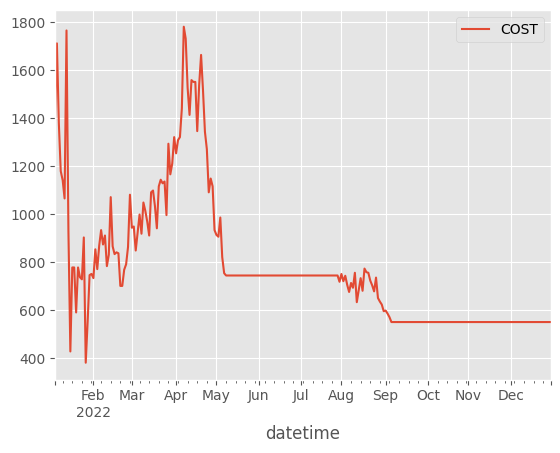

In [83]:
evb_backtest.portfolio._equity.plot(y = 'COST')

In [84]:
evb_backtest.portfolio.plot_portfolio()

In [85]:
evb_backtest.portfolio.aggregate()

Start                                                    2022-01-04 00:00:00
End                                                      2022-12-30 00:00:00
Duration                                                   360 days 00:00:00
Exposure Time [%]                                                      77.61
Equity Final [$]                                                    13237.58
Equity Peak [$]                                                 19594.254986
Return [%]                                                        -32.441518
Buy & Hold Return [%]                                             -42.017088
CAGR [%]                                                          -32.808502
Volatility Ann. [%]                                                36.161531
Sharpe Ratio                                                       -0.921121
Sortino Ratio                                                      -1.182734
Skew                                                                1.259109

In [86]:

pd.set_option('display.max_rows', 10000)
evb_backtest.portfolio.get_all_positions()

long                short  \
datetime   symbol                                             
2022-01-04 NFLX     [NFLX20220916C800]   [NFLX20220916C900]   
           AMD       [AMD20220916C150]    [AMD20220916C155]   
           COST     [COST20230120C680]   [COST20230120C700]   
           TSLA    [TSLA20220916C2025]  [TSLA20220916C2050]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-05 NFLX     [NFLX20220916C800]   [NFLX20220916C900]   
           AMD       [AMD20220916C150]    [AMD20220916C155]   
           COST     [COST20230120C680]   [COST20230120C700]   
           TSLA    [TSLA20220916C2025]  [TSLA20220916C2050]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-06 NFLX     [NFLX20220916C800]   [NFLX20220916C900]   
           AMD       [AMD20220916C150]    [AMD20220916C155]   
           COST     [COST20230120C680]   [COST20230120C700]   
           TSLA    [TSLA20220916C2025]  [TSLA20220916C2050]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-07 AMD       [AMD20220916C150]    [AMD20220916C155]   
           COST     [COST20230120C680]   [COST20230120C700]   
           TSLA    [TSLA20220916C2025]  [TSLA20220916C2050]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-10 AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-11 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-12 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-13 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-14 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-17 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-18 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-19 COST     [COST20230120C680]   [COST20230120C700]   
2022-01-20 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
2022-01-21 AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
2022-01-24 COST     [COST20230120C680]   [COST20230120C740]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C430]   [NVDA20230120C475]   
2022-01-25 AMD       [AMD20230120C195]    [AMD20230120C230]   
           COST     [COST20230120C680]   [COST20230120C740]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C430]   [NVDA20230120C475]   
2022-01-26 AMD       [AMD20230120C195]    [AMD20230120C230]   
           COST     [COST20230120C680]   [COST20230120C740]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
2022-01-27 AMD       [AMD20230120C195]    [AMD20230120C230]   
           COST     [COST20230120C680]   [COST20230120C740]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
2022-01-28 COST     [COST20230120C680]   [COST20230120C740]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
2022-01-31 COST     [COST20230120C680]   [COST20230120C740]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
2022-02-01 AMD       [AMD20230120C175]    [AMD20230120C190]   
           COST     [COST20230120C680]   [COST20230120C740]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C360]   [NVDA20230120C375]   
2022-02-02 AMD       [AMD20230120C175]    [AMD20230120C190]   
           COST     [COST20230120C680]   [COST20230120C740]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C360]   [NVDA20230120C375]   
2022-02-03 AMD       [AMD20230120C175]    [AMD20230120C190]   
  

In [87]:


""""
Why do these two return weird stuff after run?
    current_weighted_holdings
    current_positions

I can't reconcile the cost with the data (NVM, haha)

"""
# evb_backtest.portfolio.all_positions

'"\nWhy do these two return weird stuff after run?\n    current_weighted_holdings\n    current_positions\n\nI can\'t reconcile the cost with the data (NVM, haha)\n\n'

In [88]:
order_cache['2024-01-03']

{'BA': {'result': 'SUCCESSFUL',
  'data': {'long': ['BA20240920C260'],
   'short': ['BA20240920C265'],
   'trade_id': '&L:BA20240920C260&S:BA20240920C265',
   'close': 0.75}},
 'AAPL': {'result': 'SUCCESSFUL',
  'data': {'long': ['AAPL20240920C230'],
   'short': ['AAPL20240920C310'],
   'trade_id': '&L:AAPL20240920C230&S:AAPL20240920C310',
   'close': 1.0350000000000001}},
 'AMD': {'result': 'SUCCESSFUL',
  'data': {'long': ['AMD20240920C140'],
   'short': ['AMD20240920C145'],
   'trade_id': '&L:AMD20240920C140&S:AMD20240920C145',
   'close': 2.5}},
 'META': {'result': 'SUCCESSFUL',
  'data': {'long': ['META20240920C370'],
   'short': ['META20240920C375'],
   'trade_id': '&L:META20240920C370&S:META20240920C375',
   'close': 4.549999999999997}},
 'COST': {'result': 'SUCCESSFUL',
  'data': {'long': ['COST20240920C695'],
   'short': ['COST20240920C700'],
   'trade_id': '&L:COST20240920C695&S:COST20240920C700',
   'close': 4.899999999999977}},
 'NFLX': {'result': 'SUCCESSFUL',
  'data': {'

## Extend for  get_port_stats
- Buy & Hold
- Dates
- Trades
- _strategy in Aggregate
- The function

In [89]:
evb_backtest.trades.to_csv(f'/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/output/profitable_trades_options_{key}.csv')

AttributeError: 'OptionSignalBacktest' object has no attribute 'trades'